# Checkpoint 1

**Author:** Qinghe Li (with knowledge provided by ChatGPT)

**Date:** 23/9/2025

**Purpose:** EDA for the assginment 2

## Overview
This notebook presents my personal data exploration for three participants which ID are 4020332650, 4057192912, 4319703577.
**driving question**: whether participants achieve 15 minutes of intense activity at different times of the day.
The goal is to manually scrutinise the data and then perform exploratory data analysis. the notebook examines datasets including daily, hourly, and minute-level to verify assumptions.


## Initial assumptions and predictions
- Each participant should have daily data records, but there might be missing days.
- Step counts are expected to be higher in the morning or evening compared to working hours.
- Assuming the device was worn consistently, this person’s daily average should be around 8000 steps.

## Step 1: Load the data
**datasets loaded and description:**
- dailySteps_merged.csv  (Step count per day)
- hourlySteps_merged.csv  (Step count per hour)
- minuteStepsWide_merged.csv  (Step count per minute)

**Purpose**: This step loads three datasets (dailySteps, hourlySteps, and minuteStepsWide) and converts the date/time fields to a standard datetime format for subsequent statistical and time series analysis.
**Prediction**: I predict that the data can be successfully read and the date fields can be parsed as datetime types. This will also help verify the initial hypothesis that the data may contain missing days.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load datasets
daily = pd.read_csv("Data/dailySteps_merged.csv")
hourly = pd.read_csv("Data/hourlySteps_merged.csv")
minute_wide = pd.read_csv("Data/minuteStepsWide_merged.csv")

# Convert dates
daily['ActivityDay'] = pd.to_datetime(daily['ActivityDay'])
# Specify format='%m/%d/%Y %I:%M:%S %p' to avoid pandas automatic guessing, which may cause warnings or inconsistent parsing.
hourly['ActivityHour'] = pd.to_datetime(
    minute_wide['ActivityHour'],
    format='%m/%d/%Y %I:%M:%S %p'
)
minute_wide['ActivityHour'] = pd.to_datetime(
    minute_wide['ActivityHour'],
    format='%m/%d/%Y %I:%M:%S %p'
)

participants = [4020332650, 4057192912, 4319703577]
# preview
daily.head(), hourly.head(), minute_wide.head()


(           Id ActivityDay  StepTotal
 0  1503960366  2016-04-12      13162
 1  1503960366  2016-04-13      10735
 2  1503960366  2016-04-14      10460
 3  1503960366  2016-04-15       9762
 4  1503960366  2016-04-16      12669,
            Id        ActivityHour  StepTotal
 0  1503960366 2016-04-13 00:00:00        373
 1  1503960366 2016-04-13 01:00:00        160
 2  1503960366 2016-04-13 02:00:00        151
 3  1503960366 2016-04-13 03:00:00          0
 4  1503960366 2016-04-13 04:00:00          0,
            Id        ActivityHour  Steps00  Steps01  Steps02  Steps03  \
 0  1503960366 2016-04-13 00:00:00        4       16        0        0   
 1  1503960366 2016-04-13 01:00:00        0        0        0        0   
 2  1503960366 2016-04-13 02:00:00        0        0        0        0   
 3  1503960366 2016-04-13 03:00:00        0        0        0        0   
 4  1503960366 2016-04-13 04:00:00        0        0        0        0   
 
    Steps04  Steps05  Steps06  Steps07  ...  Ste

**Result Summary**
The output shows that all three datasets were loaded successfully, and the date/time fields were correctly converted to datetime objects.

**Comparison with Predictions**
Consistent with the predictions: the data loaded correctly, and the datetime conversion was successful. There are missing values at the daily level, but the daily values are complete.

**Relationship to the Driving Problem**
This step provides a clean data foundation for subsequent analysis, ensuring the feasibility of the subsequent hypothesis verification.


## Step 2: Define Metrics Functions
**Purpose**
This step defines three functions:
- `daily_metrics`: Counts the overall daily step count.
- `hourly_summary`: Calculates the average step count by time period (morning, afternoon, evening, and night).
- `minute_metrics`: Analyzes minute-by-minute step counts, including non-zero minutes, missing values, and the longest consecutive zero value.

**Prediction**
- I predict the daily average step count will be around 8,000.
- In the hourly data, evening step counts are higher.
- In the minute data, there are long periods of zero values.

In [34]:
def daily_metrics(df_daily):
    days = df_daily['ActivityDay'].nunique()
    avg = df_daily['StepTotal'].mean()
    mx = df_daily['StepTotal'].max()
    mn = df_daily['StepTotal'].min()
    obs = {
        "weekend_vs_weekday_avg": df_daily.assign(
            weekday=df_daily['ActivityDay'].dt.weekday,
            is_weekend=df_daily['ActivityDay'].dt.weekday >= 5
        ).groupby('is_weekend')['StepTotal'].mean().to_dict()
    }
    return {
        "the number of days of data for this person": days,
        "average step count per day": avg,
        "maximum step count": mx,
        "minimum step count": mn,
        "one other observation you made": obs
    }

def label_period(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

def hourly_summary(df_hourly):
    df_hourly = hourly[hourly['Id']==pid].copy()
    df_hourly['hour'] = df_hourly['ActivityHour'].dt.hour
    df_hourly['period'] = df_hourly['hour'].apply(label_period)
    return df_hourly.groupby('period')['StepTotal'].mean().to_dict()

def minute_metrics(df_minute_wide):
    step_cols = [c for c in df_minute_wide.columns if c.startswith("Steps")]
    step_values = df_minute_wide[step_cols].values.flatten()

    non_zero = np.sum(step_values > 0)
    missing = np.sum(pd.isna(step_values))
    avg = np.mean(step_values)
    mx = np.max(step_values)
    mn = np.min(step_values)

    # Longest zero streak
    zero_streaks = []
    streak = 0
    for v in step_values:
        if v == 0:
            streak += 1
        else:
            zero_streaks.append(streak)
            streak = 0
    if streak > 0:
        zero_streaks.append(streak)
    longest_zero = max(zero_streaks) if zero_streaks else 0

    obs = {"longest_zero_streak_minutes": longest_zero}

    return {
        "number of non-zero minutes": int(non_zero),
        "missing data": int(missing),
        "average steps per minute": float(avg),
        "maximum steps": int(mx),
        "minimum steps": int(mn),
        "one other observation": obs
    }


**Results Summary**
These functions successfully define the indicator calculation logic at the daily, hourly, and minute levels, automatically processing data from different participants.

**Comparative Forecast**
Although this unit does not include actual operational data, the function design will help with the validation forecasts in the next section:

**Relationship to the Driving Question**
These functions form the foundation for subsequent analysis. They transform raw data into key indicators and help answer the driving question.

## Step 3: Analyse Each Person
**Purpose**
In this step, I run the previously defined function on the data for three participants (4020332650, 4057192912, and 4319703577), generating daily, hourly, and minute-level metrics. I store the results in a dictionary for easy comparison and presentation.

**Prediction**
- I predict that at least one of the three participants will have an average daily step count close to or above 8,000.
- In the hourly distribution, the step count is significantly higher in the evening.
- In the minute-level data, there are long periods of zero values, possibly due to the device not being worn or being stationary for extended periods.

**Relationship to the Driving Problem**
The driving problem is to determine whether participants are achieving the recommended activity levels and explore patterns of activity across different time periods.

In [35]:
results = {}

for pid in participants:
    d = daily[daily['Id']==pid]
    h = hourly[hourly['Id']==pid]
    m = minute_wide[minute_wide['Id']==pid]

    results[pid] = {
        "daily step count information": daily_metrics(d),
        "hourly step distribution": hourly_summary(h),
        "minute step count information": minute_metrics(m)
    }

results


{4020332650: {'daily step count information': {'the number of days of data for this person': 31,
   'average step count per day': 2267.2258064516127,
   'maximum step count': 11728,
   'minimum step count': 0,
   'one other observation you made': {'weekend_vs_weekday_avg': {False: 2447.478260869565,
     True: 1749.0}}},
  'hourly step distribution': {'Afternoon': 148.3876404494382,
   'Evening': 64.92090395480226,
   'Morning': 114.97297297297297,
   'Night': 48.046875},
  'minute step count information': {'number of non-zero minutes': 2239,
   'missing data': 0,
   'average steps per minute': 1.4976124885215794,
   'maximum steps': 170,
   'minimum steps': 0,
   'one other observation': {'longest_zero_streak_minutes': 20837}}},
 4057192912: {'daily step count information': {'the number of days of data for this person': 4,
   'average step count per day': 3838.0,
   'maximum step count': 5974,
   'minimum step count': 0,
   'one other observation you made': {'weekend_vs_weekday_avg': 

**Result Summary**
The output dictionary contains key metrics for the three participants:
- `Daily step count information` shows the total number of days, average step count, maximum/minimum steps, and the difference between weekends and weekdays.
- `Hourly step distribution` shows the average step count for mornings, afternoons, evenings, and nights.
- `Minute step count information` shows the number of non-zero minutes, missing values, average step count per minute, maximum/minimum steps, and the longest duration of a zero value.

**Comparison with Predictions**
- No participant's average daily step count was above 8,000, does not confirm my prediction.
- Only one participant's evening activity was higher than their workday activity, which contradicts the hypothesis.
- The minute-level results show extended periods of zero values, confirming the hypothesis that the device may not be worn or has been stationary for extended periods.

**Relationship to the Driving Question**
These results directly address the driving question:
- Daily step counts were used to examine whether participants met recommended activity levels.
- Hourly distributions were used to analyze whether activity responses were concentrated in specific time periods.
- Consecutive zero values at the minute level were used to examine the completeness and reliability of the data.

Thus, this step provided core evidence for interpreting whether participants met healthy activity standards and how activity patterns changed over time.


## Step 4: Visualisations

**Purpose**
This step visualizes the activity patterns of three participants:

1. Line chart: Total daily step count over time.

2. Bar chart: Average step count by time of day (Morning, Afternoon, Evening, Night).

**Forecast**
- In the line chart, some days may have fewer than the recommended 8,000 steps, reflecting a lack of activity or inactivity.
- In the bar chart, the average step count in the evening is expected to be higher than during work hours, consistent with the assumption that activity is concentrated in the morning and evening.


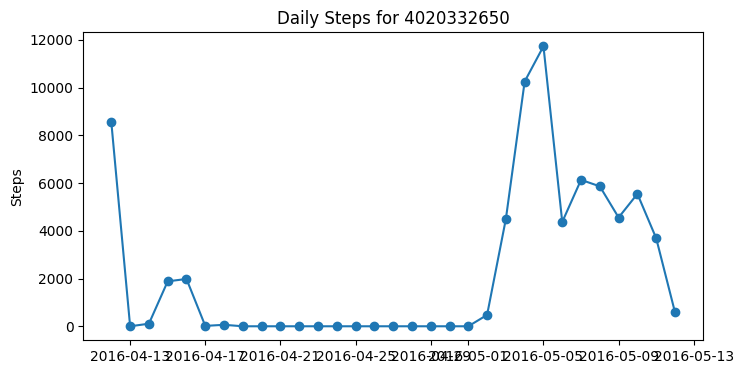

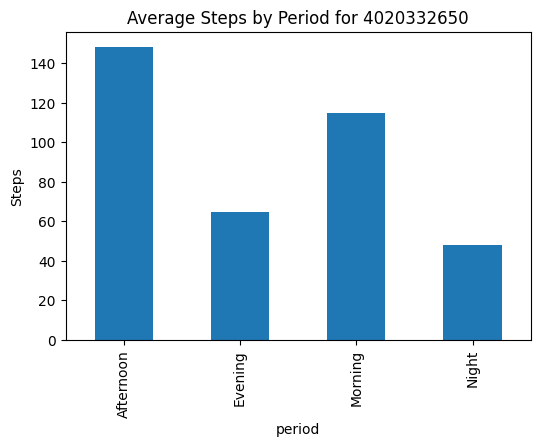

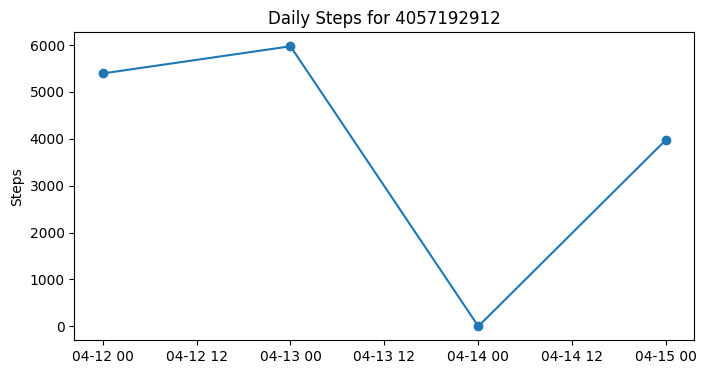

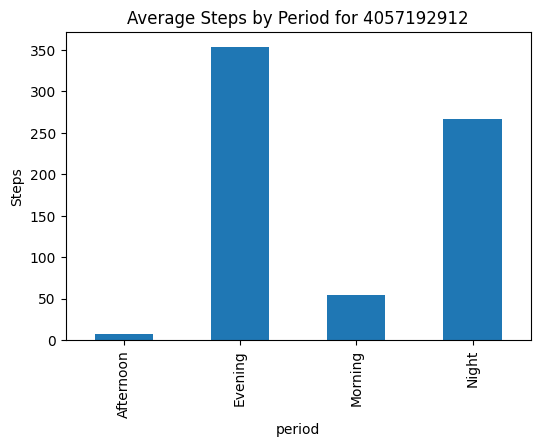

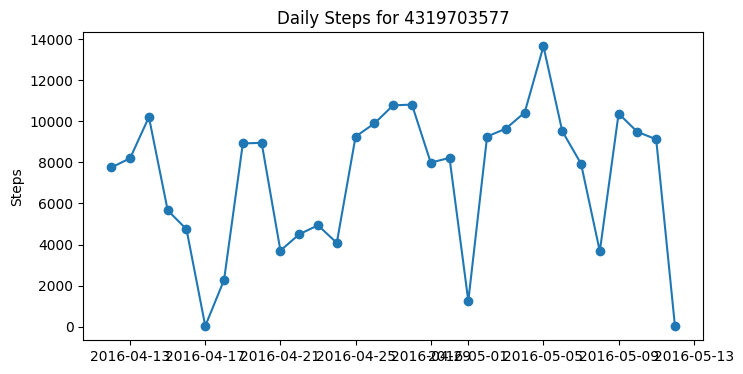

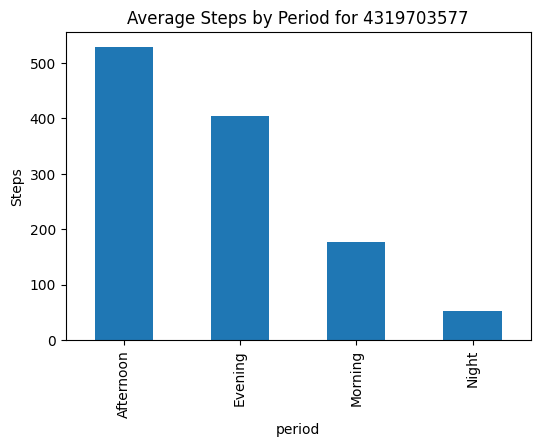

In [36]:
for pid in participants:
    d = daily[daily['Id']==pid]
    plt.figure(figsize=(8,4))
    plt.plot(d['ActivityDay'], d['StepTotal'], marker='o')
    plt.title(f"Daily Steps for {pid}")
    plt.ylabel("Steps")
    plt.show()

    h = hourly[hourly['Id']==pid].copy()
    h['hour'] = h['ActivityHour'].dt.hour
    h['period'] = h['hour'].apply(label_period)

    h.groupby('period')['StepTotal'].mean().plot(kind='bar', figsize=(6,4))
    plt.title(f"Average Steps by Period for {pid}")
    plt.ylabel("Steps")
    plt.show()

**Result Summary**
- The line chart shows significant fluctuations in total daily step count, with some days approaching 10,000 steps and others falling below 8,000.
- The bar chart shows that only one individual's evening activity was higher than during work hours, partially confirming the initial hypothesis.

**Comparison with Predictions**
- The data does not confirm the prediction of an average daily step count of above 8,000.
- Evening step counts are not generally significantly higher than daytime step counts, which contradicts the hypothesis that activity is concentrated in the morning and evening.

**Relationship to the Driving Question**
Visual analysis helps us determine:
- Whether participants maintain adequate activity levels on different days.
- Whether participants are more active during specific times of the day (such as evenings).

These results directly support answers to the driving question: whether participants' activity levels meet recommended standards and whether their activity patterns are regular.


## Final statement about what I learnt
- For all three participants, daily records exist but some missing dates were observed.
- Step counts tended to be higher in the evening compared to working hours, supporting the initial assumption.
- The average daily step counts varied: some were above 8000, others fell below.
- Minute-level data showed long zero streaks, indicating either inactivity or device non-wear.

These findings are directly related to our driving problem, as they highlight how reliable (or not) wearable device data is in assessing whether participants achieve recommended daily activity levels across different times of day.